In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

In [23]:
# Load S&P 500 prices
sp500_prices = pd \
    .read_csv("../data/raw/tessa_sp500_prices.csv") \
    .drop(columns=['GEV', 'SOLV', 'SW']) \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)
    
# Load NCI prices
nci_prices = pd \
    .read_csv("../data/raw/tessa_nci_prices.csv") \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)

# Left join on S&P
data = pd.merge(sp500_prices, nci_prices, on="date", how="left")

data.head(3)

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,ZTS,ADA-USD,AVAX-USD,BTC-USD,ETH-USD,LINK-USD,LTC-USD,SOL-USD,UNI-USD,XRP-USD
date,,,,,,,,,,,,,,,,,,,,,
2024-03-15,146.463730,171.808746,171.628006,160.639999,113.183418,87.368553,370.019684,492.459991,192.012970,57.146446,...,170.748978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-18,145.083298,172.903580,172.216553,161.860001,110.194344,86.912125,368.113281,513.859985,188.097961,58.206318,...,168.888824,0.661258,60.689945,67548.593750,3517.985107,18.324354,87.112206,195.992752,0.000217,0.647565
2024-03-19,146.374374,175.252502,173.345444,161.789993,110.899956,87.168869,373.457123,521.190002,187.429062,58.803699,...,171.134842,0.586914,53.525894,61912.773438,3157.618164,16.809296,78.586372,170.016281,0.000198,0.584441


In [24]:
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

For stationarity checks, I referred briefly to this paper: https://business.columbia.edu/sites/default/files-efs/pubfiles/3970/computing_efficient_frontiers.pdf section 8 

## Stationarity check on daily prices

In [3]:
def check_stationarity_price(data: pd.DataFrame) -> dict:
    """
    Perform Augmented Dickey-Fuller (ADF) test on all asset price series in the dataset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.

    Returns:
        data (pd.DataFrame): DataFrame with asset names and their stationarity status (1 = stationary, 0 = non-stationary).
    """
    results = {"Asset": [], "Stationary": []}

    for asset in data.columns:
        series = data[asset].dropna()
        result = adfuller(series)
        p_value = result[1]
        
        # Stationary if p-value < 0.05
        results["Asset"].append(asset)
        results["Stationary"].append(1 if p_value < 0.05 else 0)

    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results)

    return results_df


In [4]:
results_price = check_stationarity_price(data)
(results_price["Stationary"] == 0).sum()

488

In [5]:
def plot_daily_price(data: pd.DataFrame, asset_name: str):
    """
    Plot the daily price for a specific asset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.
        asset_name (str): The asset name (column) to plot returns for.
    """
    series_asset = data[asset_name].dropna()
    result_asset = adfuller(series_asset)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(series_asset, label=f'Daily Price - {asset_name}')

    # Set title and labels
    ax.set_title(f'Daily Price of {asset_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Price')

    # Format x-axis to show months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

    ax.legend()
    ax.grid(True)

    plt.savefig(f"../figures/{asset_name}_prices.png", dpi=300)  

    plt.show()

    print(result_asset[1])


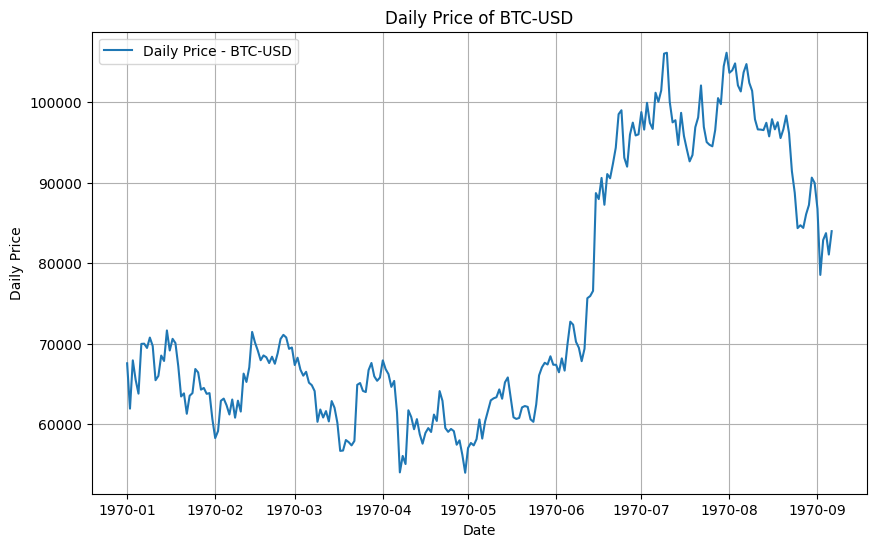

0.6624071195859544


In [6]:
plot_daily_price(data, 'BTC-USD')

## Stationarity check on daily returns 

In [25]:
def check_stationarity_all(data: pd.DataFrame) -> dict:
    """
    Perform Augmented Dickey-Fuller (ADF) test on daily returns of each asset 

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.

    Returns:
        data (pd.DataFrame): DataFrame with asset names and their stationarity status (1 = stationary, 0 = non-stationary).
    """
    results = {"Asset": [], "Stationary": []}
    daily_returns = data.pct_change()

    for asset in data.columns:
        series = daily_returns[asset].dropna()
        result = adfuller(series)
        p_value = result[1]
        
        # Stationary if p-value < 0.05
        results["Asset"].append(asset)
        results["Stationary"].append(1 if p_value < 0.05 else 0)

    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results)

    return results_df


In [26]:
# Run stationarity check for all assets
results = check_stationarity_all(data)
results

,Asset,Stationary
0,A,1
1,AAPL,1
2,ABBV,1
3,ABNB,1
4,ABT,1
...,...,...
502,LINK-USD,1
503,LTC-USD,1
504,SOL-USD,1
505,UNI-USD,1


In [27]:
(results["Stationary"] == 0).sum()

0

In [30]:
def plot_daily_returns(data: pd.DataFrame, asset_name: str):
    """
    Plot the daily returns for a specific asset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.
        asset_name (str): The asset name (column) to plot returns for.
    """
    # Calculate daily returns
    daily_returns = data.pct_change()

    series_asset = daily_returns[asset_name].dropna()
    result_asset = adfuller(series_asset)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(series_asset, label=f'Daily Return - {asset_name}')

    # Set title and labels
    ax.set_title(f'Daily Return of {asset_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Return')

    # Format x-axis to show months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

    ax.legend()
    ax.grid(True)

    plt.savefig(f"../figures/{asset_name}_returns.png", dpi=300)

    plt.show()

    print(result_asset[1])


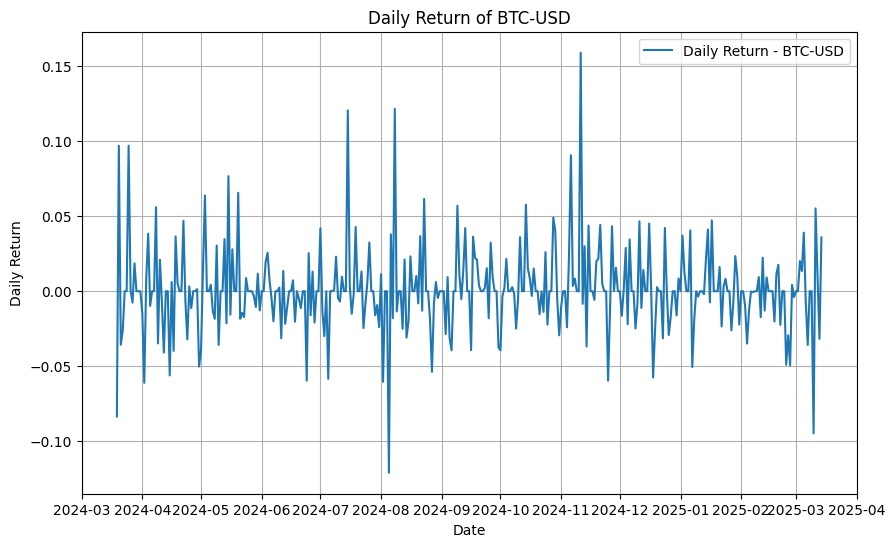

0.0


In [31]:
plot_daily_returns(data, 'BTC-USD')

## Time series plots / EDA

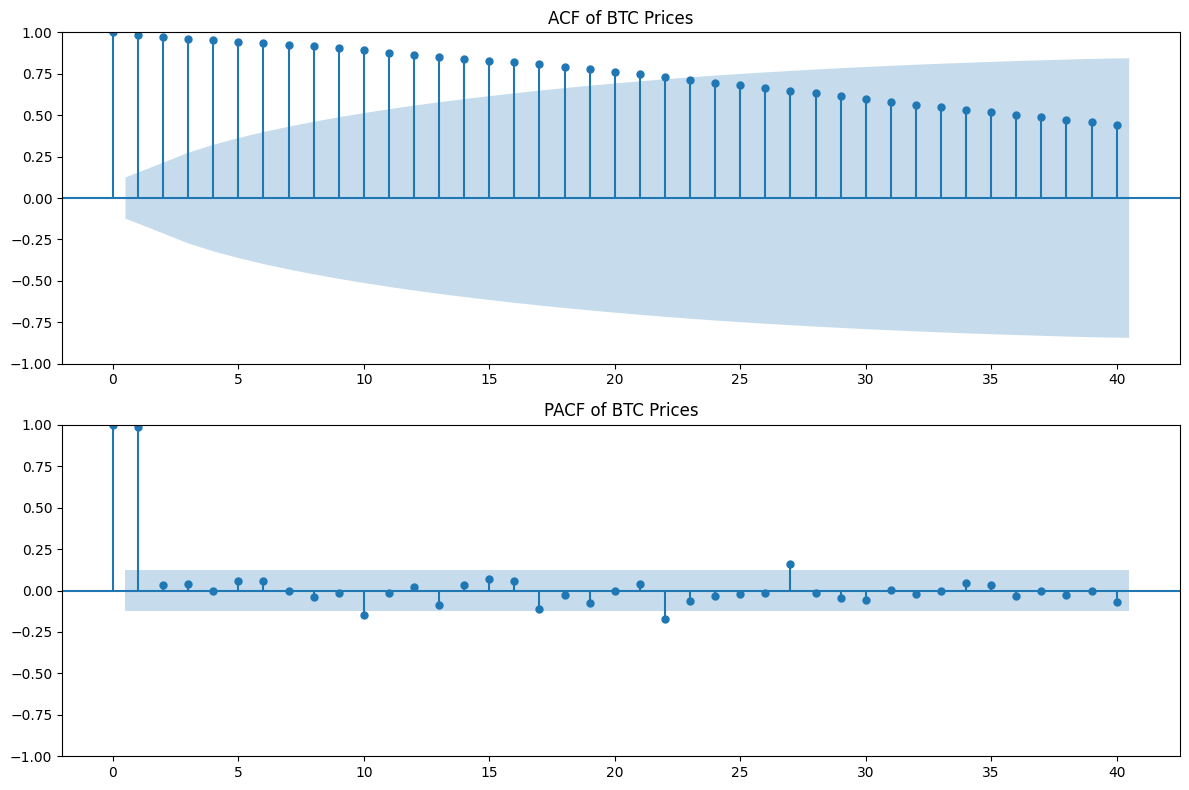

In [8]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(data['BTC-USD'].dropna(), ax=ax[0], lags=40)
ax[0].set_title("ACF of BTC Prices")

plot_pacf(data['BTC-USD'].dropna(), ax=ax[1], lags=40)
ax[1].set_title("PACF of BTC Prices")

plt.tight_layout()
plt.savefig("../figures/btc_acf_pacf.png", dpi=300)  
plt.show()

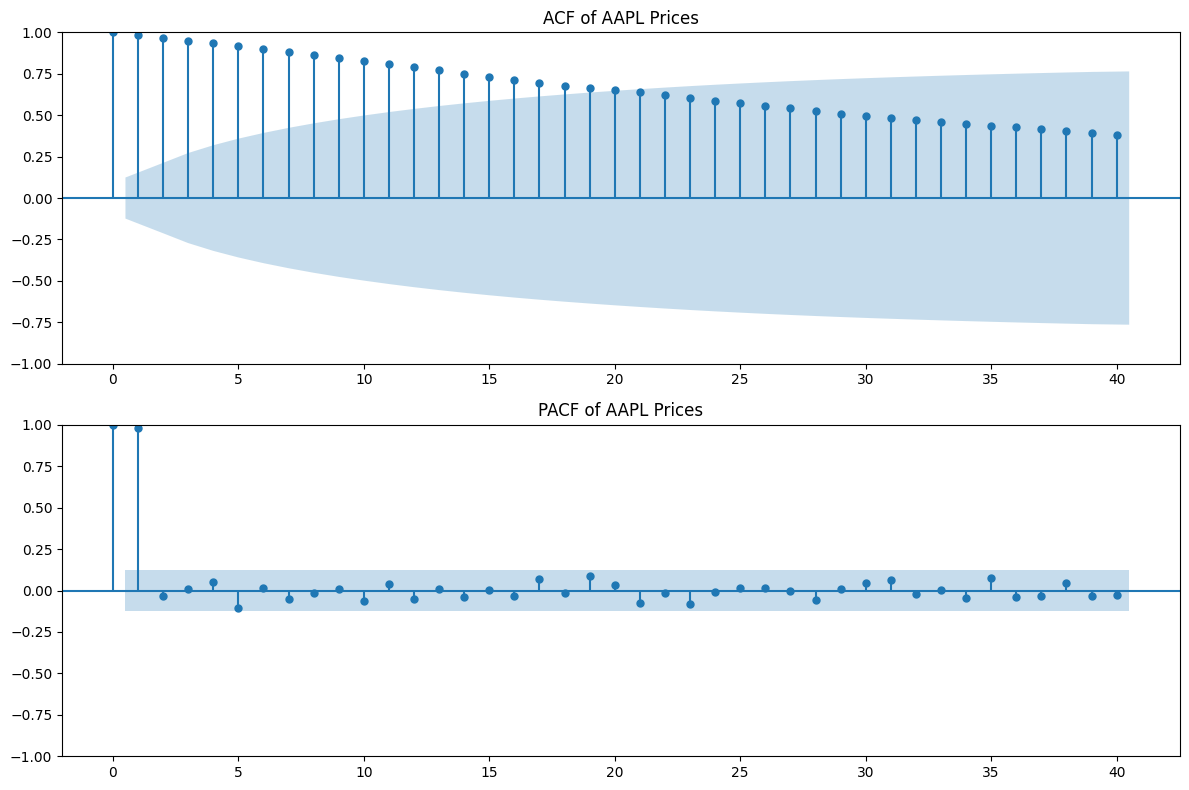

In [9]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(data['AAPL'].dropna(), ax=ax[0], lags=40)
ax[0].set_title("ACF of AAPL Prices")

plot_pacf(data['AAPL'].dropna(), ax=ax[1], lags=40)
ax[1].set_title("PACF of AAPL Prices")

plt.tight_layout()
plt.savefig("../figures/aapl_acf_pacf.png", dpi=300)  
plt.show()

## AR Models

Modelling fitting using Box-Jenkins procedure

In [32]:
def fit_best_arma(series):
    """ Fit AR, MA, or ARMA model and return the best based on AIC """
    best_bic = np.inf # Use BIC as
    best_order = None
    best_model = None
    
    for p in range(3):  # Grid search for p = 0, 1, 2
        for q in range(3):  # Grid search for q = 0, 1, 2
            try:
                model = ARIMA(series, order=(p, 0, q)).fit()
                if model.bic < best_bic:
                    best_aic = model.bic
                    best_order = (p, 0, q)
                    best_model = model

            except:
                continue
    
    return best_model, best_order, best_aic

In [33]:
def analyze_assets(data):
    """ Apply Box-Jenkins methodology to all assets """
    results = []
    
    for asset in data.columns:
        print(f"analysing {asset}")
        series = data[asset].pct_change().dropna()
        best_model, best_order, best_bic = fit_best_arma(series)
        
        if best_model:
            results.append({"Asset": asset, "Best Model": best_order, "BIC": best_bic})
    
    return pd.DataFrame(results)

In [19]:
warnings.filterwarnings("ignore")

results_df = analyze_assets(data)

analysing A
analysing AAPL
analysing ABBV
analysing ABNB
analysing ABT
analysing ACGL
analysing ACN
analysing ADBE
analysing ADI
analysing ADM
analysing ADP
analysing ADSK
analysing AEE
analysing AEP
analysing AES
analysing AFL
analysing AIG
analysing AIZ
analysing AJG
analysing AKAM
analysing ALB
analysing ALGN
analysing ALL
analysing ALLE
analysing AMAT
analysing AMCR
analysing AMD
analysing AME
analysing AMGN
analysing AMP
analysing AMT
analysing AMZN
analysing ANET
analysing ANSS
analysing AON
analysing AOS
analysing APA
analysing APD
analysing APH
analysing APO
analysing APTV
analysing ARE
analysing ATO
analysing AVB
analysing AVGO
analysing AVY
analysing AWK
analysing AXON
analysing AXP
analysing AZO
analysing BA
analysing BAC
analysing BALL
analysing BAX
analysing BBY
analysing BDX
analysing BEN
analysing BG
analysing BIIB
analysing BK
analysing BKNG
analysing BKR
analysing BLDR
analysing BLK
analysing BMY
analysing BR
analysing BRO
analysing BSX
analysing BWA
analysing BX
analy

In [34]:
results_df

,Asset,Best Model,BIC
0,A,"(2, 0, 2)",-2057.004600
1,AAPL,"(2, 0, 2)",-2100.259412
2,ABBV,"(2, 0, 2)",-2097.642307
3,ABNB,"(2, 0, 2)",-1822.919347
4,ABT,"(2, 0, 2)",-2271.206600
...,...,...,...
502,LINK-USD,"(2, 0, 2)",-1107.812761
503,LTC-USD,"(2, 0, 2)",-1223.840144
504,SOL-USD,"(2, 0, 2)",-1212.079969
505,UNI-USD,"(2, 0, 2)",-1330.874683


In [35]:
results_df['Best Model'].value_counts() #(2,0,2) for all asset types 

Best Model
(2, 0, 2)    507
Name: count, dtype: int64

In [36]:
# want to do residual analysis? 